## Experimental Functions for Cumulative Entropy and Mutual Information

These functions compute the mutual information based on the cumulative distribution function rather than the density as it is done in traditional definitions.

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
random.seed(4408765) 

In [2]:
def xy_cor(N, rho, truncate=True):
    "This function generates two N-element Gaussian random vectors with correlation rho"
    xx = np.array([0, 1])
    yy = np.array([0, 1])
    means = [0, 1]  
    stds = [0.5, 0.5]
    covs = [[stds[0]**2, stds[0]*stds[1]*rho], 
        [stds[0]*stds[1]*rho, stds[1]**2]] 
    m = np.random.multivariate_normal(means, covs, N).T
    x = (m[0] - np.mean(m[0]))/np.std(m[0])
    y = (m[1] - np.mean(m[1]))/np.std(m[1])
    if (truncate == True):
        x = (x - np.min(x))/(np.max(x) - np.min(x))
        y = (y - np.min(y))/(np.max(y) - np.min(y))
        thres = 3
        for i in range(N):
            if x[i] > thres:
                x[i] = thres
            if x[i] < -thres:
                x[i] = -thres
            if y[i] > thres:
                y[i] = thres
            if y[i] < -thres:
                y[i] = -thres  
    return (x, y)

### Define the Cumulative Mutual Information function based on the difference between joint and marginals Cumulative Entropies

$$CMI(x, y) = (max(x) - \bar{x}) CE(y) + (max(y) - \bar{y}) CE(x) - CE(x, y)$$

In [3]:
def CMI_diff(x, y):
    "This function computes the Cumulative Mutual Information based on the difference between joint and marginals CE's"
    x = x - np.mean(x)
    y = y - np.mean(y)
    N = len(x)
    lattice_x = np.zeros((N, N), dtype="float_")    # Array of lower x tile coordinates
    lattice_y = np.zeros((N, N), dtype="float_")     # Array of lower y tile coordinates
    lattice_area = np.zeros((N, N), dtype="float_")   # Array of tile areas
    lattice_count = np.zeros((N, N), dtype="uint8")    # Array of tile data counts
    x_order = np.argsort(x, kind='quicksort')
    x_sorted = x[x_order]
    y_order = np.argsort(y, kind='quicksort')
    y_sorted = y[y_order]
    ind = np.arange(0, N, 1)
    ind_x_order = np.argsort(x_order, kind='quicksort') 
    ind_x = ind[ind_x_order]
    ind_y_order = np.argsort(y_order, kind='quicksort') 
    ind_y = ind[ind_y_order]
    for i in range(N):
        for j in range(N):
            lattice_x[i, j] = x_sorted[i]
            lattice_y[i, j] = y_sorted[j]
            if i < (N-1) and j < (N-1):
                lattice_area[i, j] = (x_sorted[i+1] - x_sorted[i])*(y_sorted[j+1] - y_sorted[j])
        
    for i in range(N): 
        lattice_count[ind_x[i], ind_y[i]] = 1 

    np.cumsum(lattice_count, axis=1, out=lattice_count)
    np.cumsum(lattice_count, axis=0, out=lattice_count)
    CDF_xy = lattice_count/float(N)
    CDF_x = np.arange(0, N, 1)/float(N)
    CDF_y = CDF_x
    CE_x = 0
    CE_y = 0
    for i in range(N-1):
        if CDF_x[i] != 0:
            CE_x = CE_x - (x_sorted[i+1] - x_sorted[i]) * CDF_x[i] * math.log(CDF_x[i])
        if CDF_y[i] != 0:       
            CE_y = CE_y - (y_sorted[i+1] - y_sorted[i]) * CDF_y[i] * math.log(CDF_y[i])

    CE_xy = 0
    for i in range(N):
        for j in range(N):
            if CDF_xy[i, j] != 0:
                CE_xy = CE_xy - lattice_area[i, j] * CDF_xy[i, j] * math.log(CDF_xy[i, j])
             
    # Compute the CMI based on the difference between joint and marginals CE's        
            
    CMI = CE_xy - (max(y) - np.mean(y))*CE_x - (max(x) - np.mean(x))*CE_y  
    if CMI < 0:
        CMI = 0

    return (CMI/(np.max(x)*np.max(y)))

### Define the Cumulative Mutual Information function based on the ratio of joint and marginals Cumulative Entropies

$$CMI(x, y) = \int \int P(x,y) \log \left ( \frac{P(x,y)}{P(x)P(y)} \right ) dx dy$$

In [4]:
def CMI_ratio(x, y):
    "This function computes the Cumulative Mutual Information based on the ratio of joint and marginals CE's"      
    x = x - np.mean(x)
    y = y - np.mean(y)
    N = len(x)
    lattice_x = np.zeros((N, N), dtype="float_")    # Array of lower x tile coordinates
    lattice_y = np.zeros((N, N), dtype="float_")     # Array of lower y tile coordinates
    lattice_area = np.zeros((N, N), dtype="float_")   # Array of tile areas
    lattice_count = np.zeros((N, N), dtype="uint8")    # Array of tile data counts
    x_order = np.argsort(x, kind='quicksort')
    x_sorted = x[x_order]
    y_order = np.argsort(y, kind='quicksort')
    y_sorted = y[y_order]
    ind = np.arange(0, N, 1)
    ind_x_order = np.argsort(x_order, kind='quicksort') 
    ind_x = ind[ind_x_order]
    ind_y_order = np.argsort(y_order, kind='quicksort') 
    ind_y = ind[ind_y_order]
    for i in range(N):
        for j in range(N):
            lattice_x[i, j] = x_sorted[i]
            lattice_y[i, j] = y_sorted[j]
            if i < (N-1) and j < (N-1):
                lattice_area[i, j] = (x_sorted[i+1] - x_sorted[i])*(y_sorted[j+1] - y_sorted[j])
        
    for i in range(N): 
        lattice_count[ind_x[i], ind_y[i]] = 1 

    np.cumsum(lattice_count, axis=1, out=lattice_count)
    np.cumsum(lattice_count, axis=0, out=lattice_count)
    CDF_xy = lattice_count/float(N)
    CDF_x = np.arange(0, N, 1)/float(N)
    CDF_y = CDF_x
    
    # Compute the CMI based on the ratio of joint and marginals CE's
    
    CMI = 0
    for i in range(N):
        for j in range(N):
            if CDF_x[i] != 0 and CDF_y[j] != 0 and CDF_xy[i, j] != 0:
                CMI = CMI - lattice_area[i, j] * CDF_xy[i, j] * math.log(CDF_xy[i, j])/(CDF_x[i]*CDF_y[j])
        
    return (CMI/(np.max(x)*np.max(y)))

### Generate correlated random data for incremental values of the correlation between x and y

In [12]:
N = 100          # Number of x and y data points
inst = 200

corrs = np.arange(0, 1.005, 0.1)
T = len(corrs)
CMI_aver_diff = np.zeros((T), dtype="float_") 
CMI_aver_ratio = np.zeros((T), dtype="float_") 

for t in range(T):
    CMI_diff_vals = np.zeros(inst, dtype="float_") 
    CMI_ratio_vals = np.zeros(inst, dtype="float_") 
    for k in range(inst):
        (x, y) = xy_cor(N, corrs[t], truncate=False)        
        CMI_diff_vals[k] = CMI_diff(x, y)  
        CMI_ratio_vals[k] = CMI_ratio(x, y)
  
    CMI_aver_diff[t] = np.mean(CMI_diff_vals)
    CMI_aver_ratio[t] = np.mean(CMI_ratio_vals)
    



/Users/tamayo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: covariance is not positive-semidefinite.


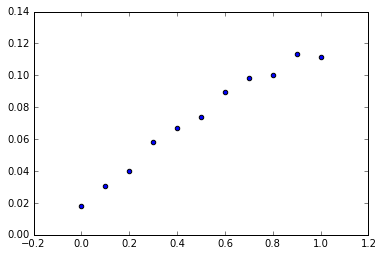

In [13]:
plt.scatter(corrs, CMI_aver_diff)

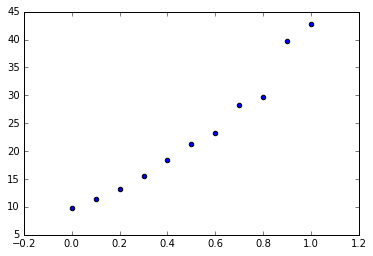

In [14]:
plt.scatter(corrs, CMI_aver_ratio)

### Basic timings

In [15]:
x = np.random.uniform(low=0.0, high=1.0, size=200)
y = np.random.uniform(low=0.0, high=1.0, size=200)

N = 100
start_time = time.time()
for i in range(N):
    z = CMI_diff(x, y)

end_time = time.time() 
print("Execution time %s seconds per function call " % ((end_time - start_time)/N))

start_time = time.time()
for i in range(N):
    z = CMI_ratio(x, y)

end_time = time.time() 
print("Execution time %s seconds per function call " % ((end_time - start_time)/N))

Execution time 0.08793322801589966 seconds per function call 
Execution time 0.12226523876190186 seconds per function call 


### Test normalization vs. linear rescaling of the input variables

In [16]:
# Generate correlated x and y vectors

(x, y) = xy_cor(200, 0.5, truncate=False)  

# Rescaled versions of the vectors

x2 = 20*x + 234
x3 = x/3 - 0.6
y2 = 10*y + 10
y3 = y/2 - 989

print(CMI_diff(x, y))
print(CMI_diff(x2, y2))
print(CMI_diff(x3, y3))
print("-------------")
print(CMI_ratio(x, y))
print(CMI_ratio(x2, y2))
print(CMI_ratio(x3, y3))

0.045177453834
0.045177453834
0.045177453834
-------------
17.0658584452
17.0658584452
17.0658584452


### References: 

Di Crescenzo and Logobardi. On cumulative entropies. Journal of Statistical Planning and Inference 12/2009; 139:4072-4087.
https://www.researchgate.net/publication/48191880_On_cumulative_entropies